
测试集表现：
R²: 0.9844, MAE: 0.0317, RMSE: 0.148

最佳参数组合：
OrderedDict({'bootstrap': False, 'max_depth': 23, 'max_features': 0.3367490792561527, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000})


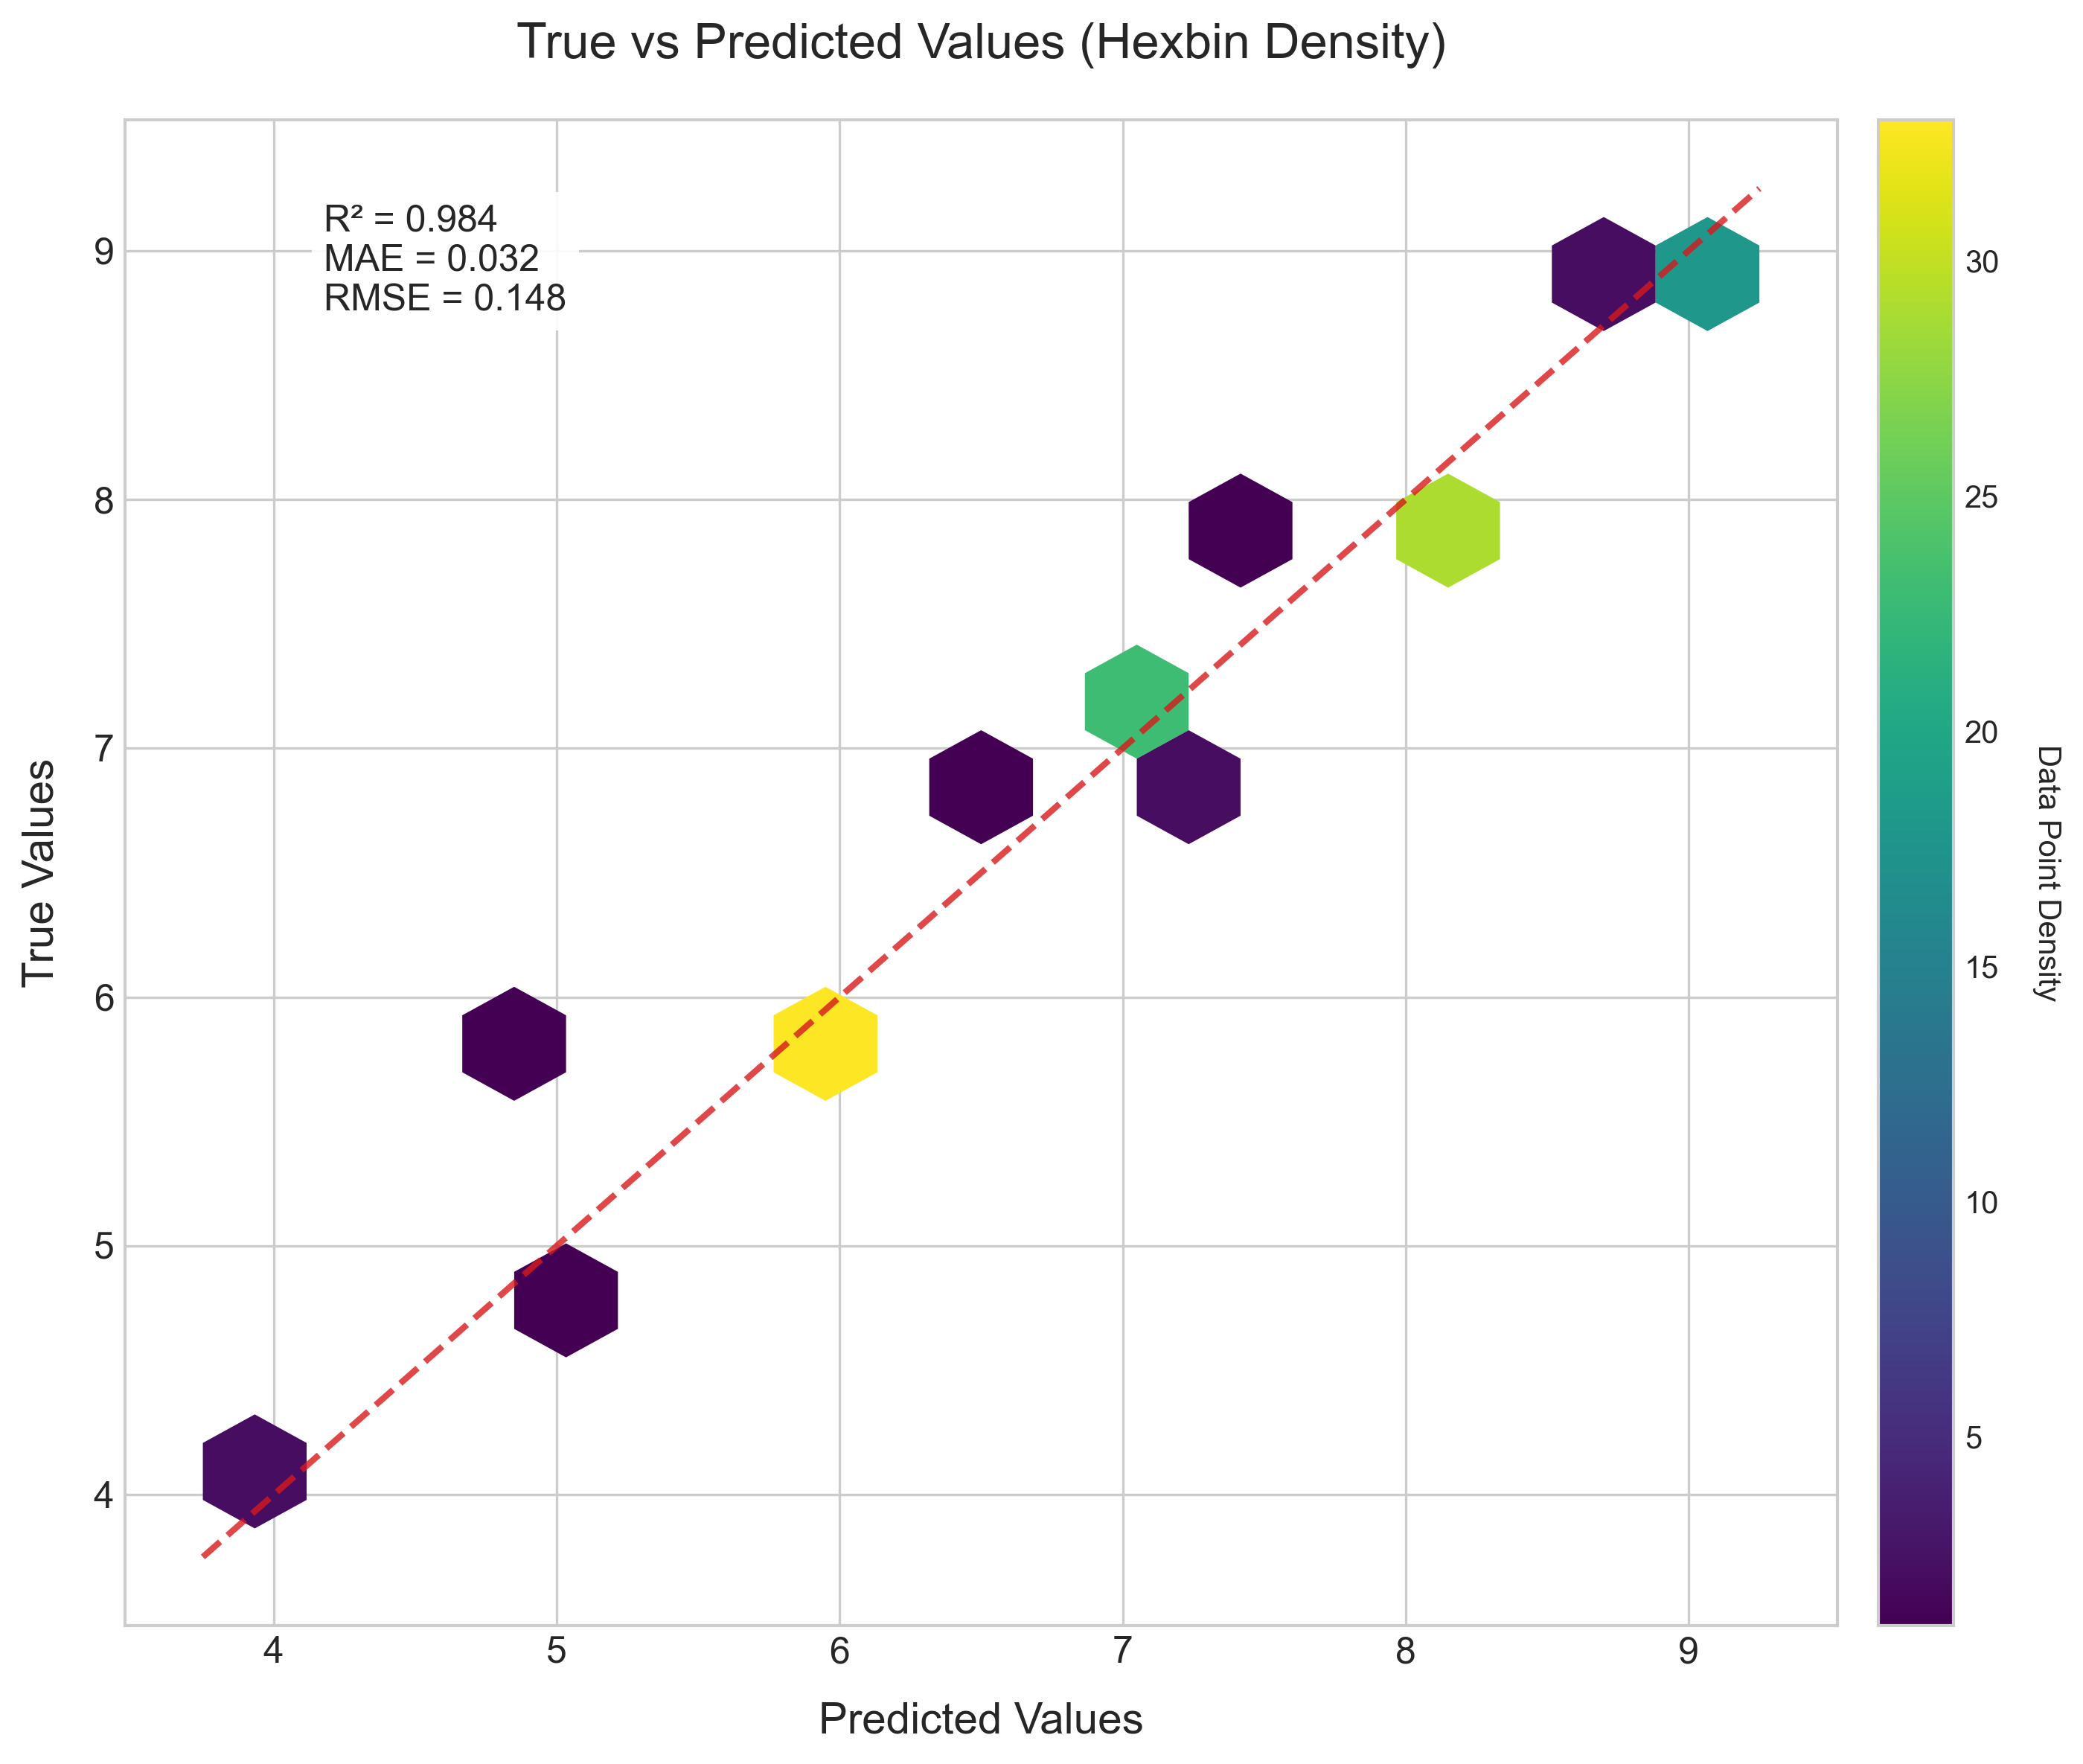

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Integer, Real

# 设置全局种子
SEED = 777
np.random.seed(SEED)

# 数据加载和预处理
data = pd.read_csv('1.csv')
X = data.drop('Quality of Sleep', axis=1)
y = data['Quality of Sleep']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

# 归一化处理
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定义随机森林模型
rf = RandomForestRegressor(random_state=SEED)

# 贝叶斯优化超参数空间
param_space = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 30),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Real(0.1, 1.0, prior='uniform'),
    'bootstrap': [True, False]
}

# 贝叶斯优化设置
bayes_cv = BayesSearchCV(
    estimator=rf,
    search_spaces=param_space,
    scoring='neg_mean_absolute_error',  # 使用MAE作为优化目标
    cv=5,  # 5折交叉验证
    n_iter=30,  # 贝叶斯优化迭代次数
    n_jobs=-1,
    random_state=SEED
)

# 执行贝叶斯优化
bayes_cv.fit(X_train_scaled, y_train)

# 最佳模型
best_rf = bayes_cv.best_estimator_

# 训练集预测
y_train_pred = best_rf.predict(X_train_scaled)

# 测试集预测
y_test_pred = best_rf.predict(X_test_scaled)

# 评估函数
def evaluate(y_true, y_pred):
    return {
        'R2': round(r2_score(y_true, y_pred), 4),
        'MAE': round(mean_absolute_error(y_true, y_pred), 4),
        'RMSE': round(np.sqrt(mean_squared_error(y_true, y_pred)), 4)
    }

# 输出结果
test_metrics = evaluate(y_test, y_test_pred)


print("\n测试集表现：")
print(f"R²: {test_metrics['R2']}, MAE: {test_metrics['MAE']}, RMSE: {test_metrics['RMSE']}")

# 输出最佳参数
print("\n最佳参数组合：")
print(bayes_cv.best_params_)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 8), dpi=300)

# 计算坐标轴范围
data_min = min(y_test.min(), y_test_pred.min())
data_max = max(y_test.max(), y_test_pred.max())
buffer = (data_max - data_min) * 0.05  # 5%边界缓冲

# 创建六边形分箱图
hexbin = plt.hexbin(y_test_pred, y_test,
                   gridsize=15,            # 控制分箱粒度
                   cmap='viridis',         # 使用色盲友好色谱
                   mincnt=1,              # 显示至少包含1个点的分箱
                   edgecolors='none',     # 移除分箱边界线
                   extent=(data_min - buffer, data_max + buffer, 
                           data_min - buffer, data_max + buffer))

# 添加参考线
ref_line = np.linspace(data_min - buffer, data_max + buffer, 100)
plt.plot(ref_line, ref_line, '--', color='#d7191c', lw=2, alpha=0.8)

# 添加颜色条
cbar = plt.colorbar(hexbin, pad=0.02)
cbar.set_label('Data Point Density', rotation=270, labelpad=20)

# 添加统计标注
stats_text = (
    f"R² = {test_metrics['R2']:.3f}\n"
    f"MAE = {test_metrics['MAE']:.3f}\n"
    f"RMSE = {test_metrics['RMSE']:.3f}"
)
plt.gcf().text(0.15, 0.82, stats_text, 
              fontsize=12,
              bbox=dict(facecolor='white', alpha=0.9, edgecolor='none'))

# 设置坐标轴
plt.xlabel('Predicted Values', fontsize=14, labelpad=10)
plt.ylabel('True Values', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 设置标题
plt.title('True vs Predicted Values (Hexbin Density)', 
         fontsize=16, pad=20)

# 保存矢量图
plt.savefig('hexbin_plot.pdf', bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()


测试集表现：
R²: 0.9851, MAE: 0.0241, RMSE: 0.1449

最佳参数组合：
OrderedDict({'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.29999999999999993, 'max_depth': 30, 'min_child_weight': 1, 'n_estimators': 1000, 'reg_alpha': 0.0, 'reg_lambda': 10.0, 'subsample': 0.5})


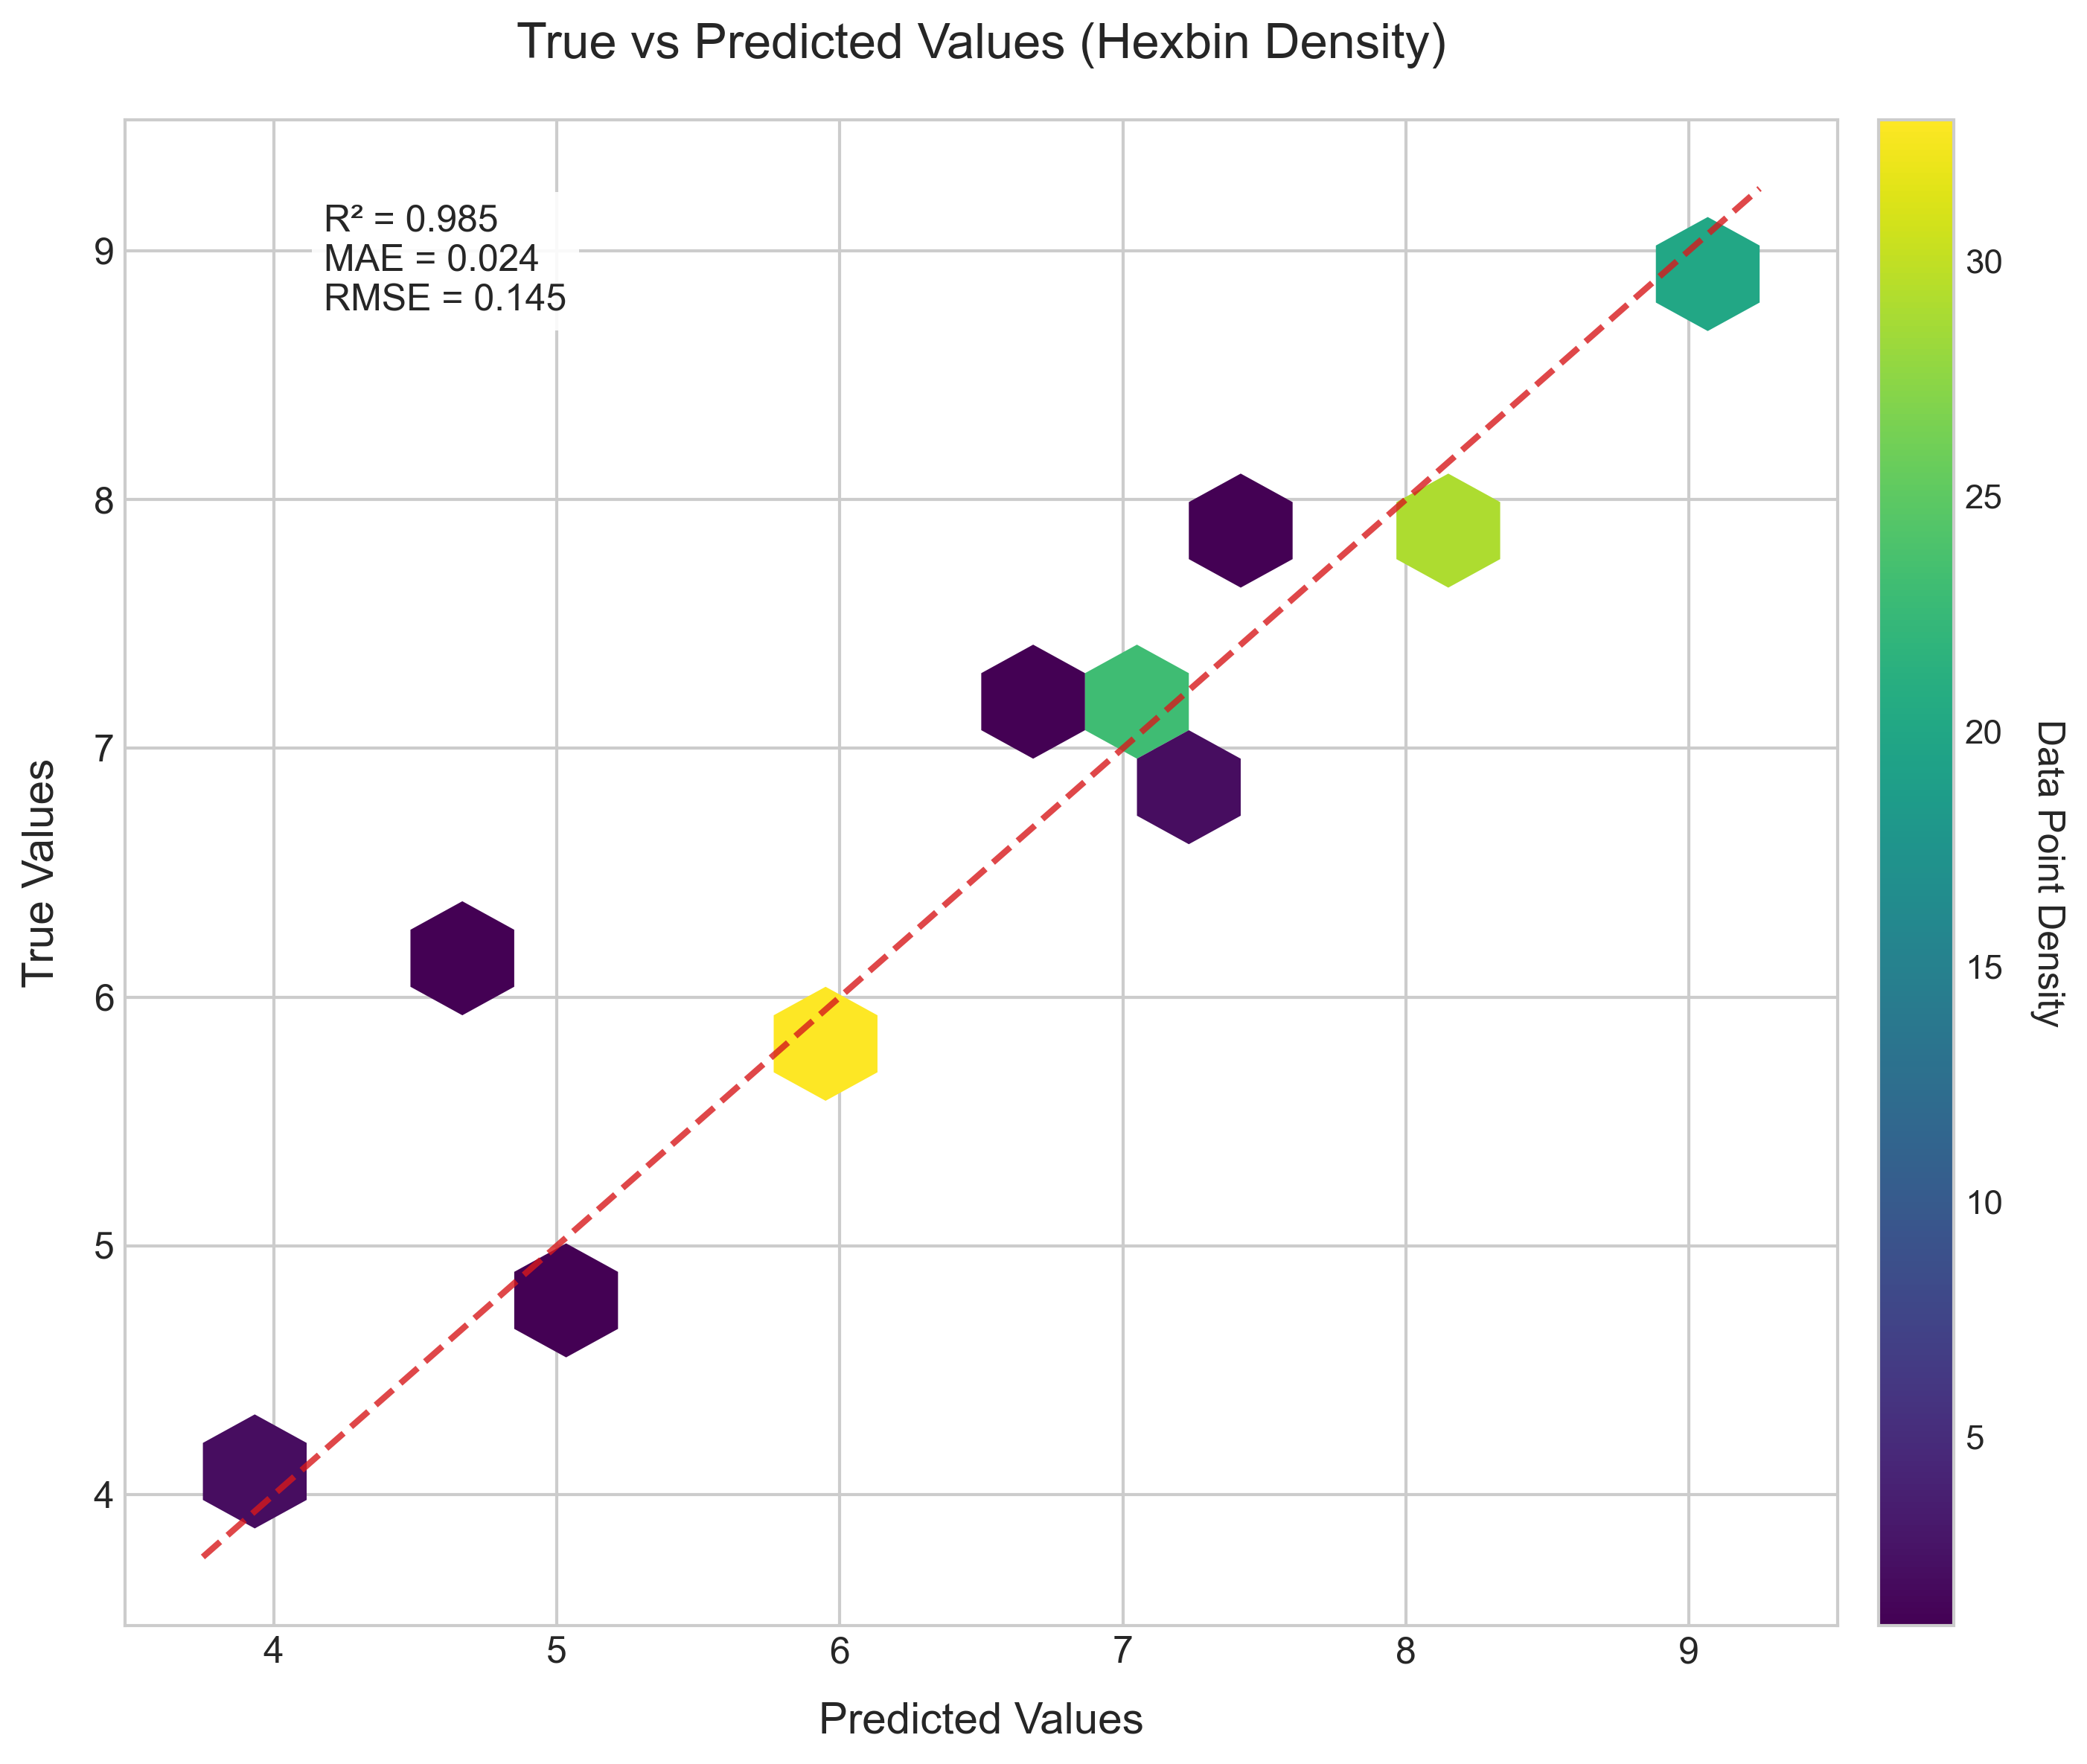

/var/folders/57/pzlc1dds0gnd1ywkc5_837rh0000gn/T/ipykernel_92525/2280228111.py:152: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_test_scaled, feature_names=X.columns, plot_type="bar")


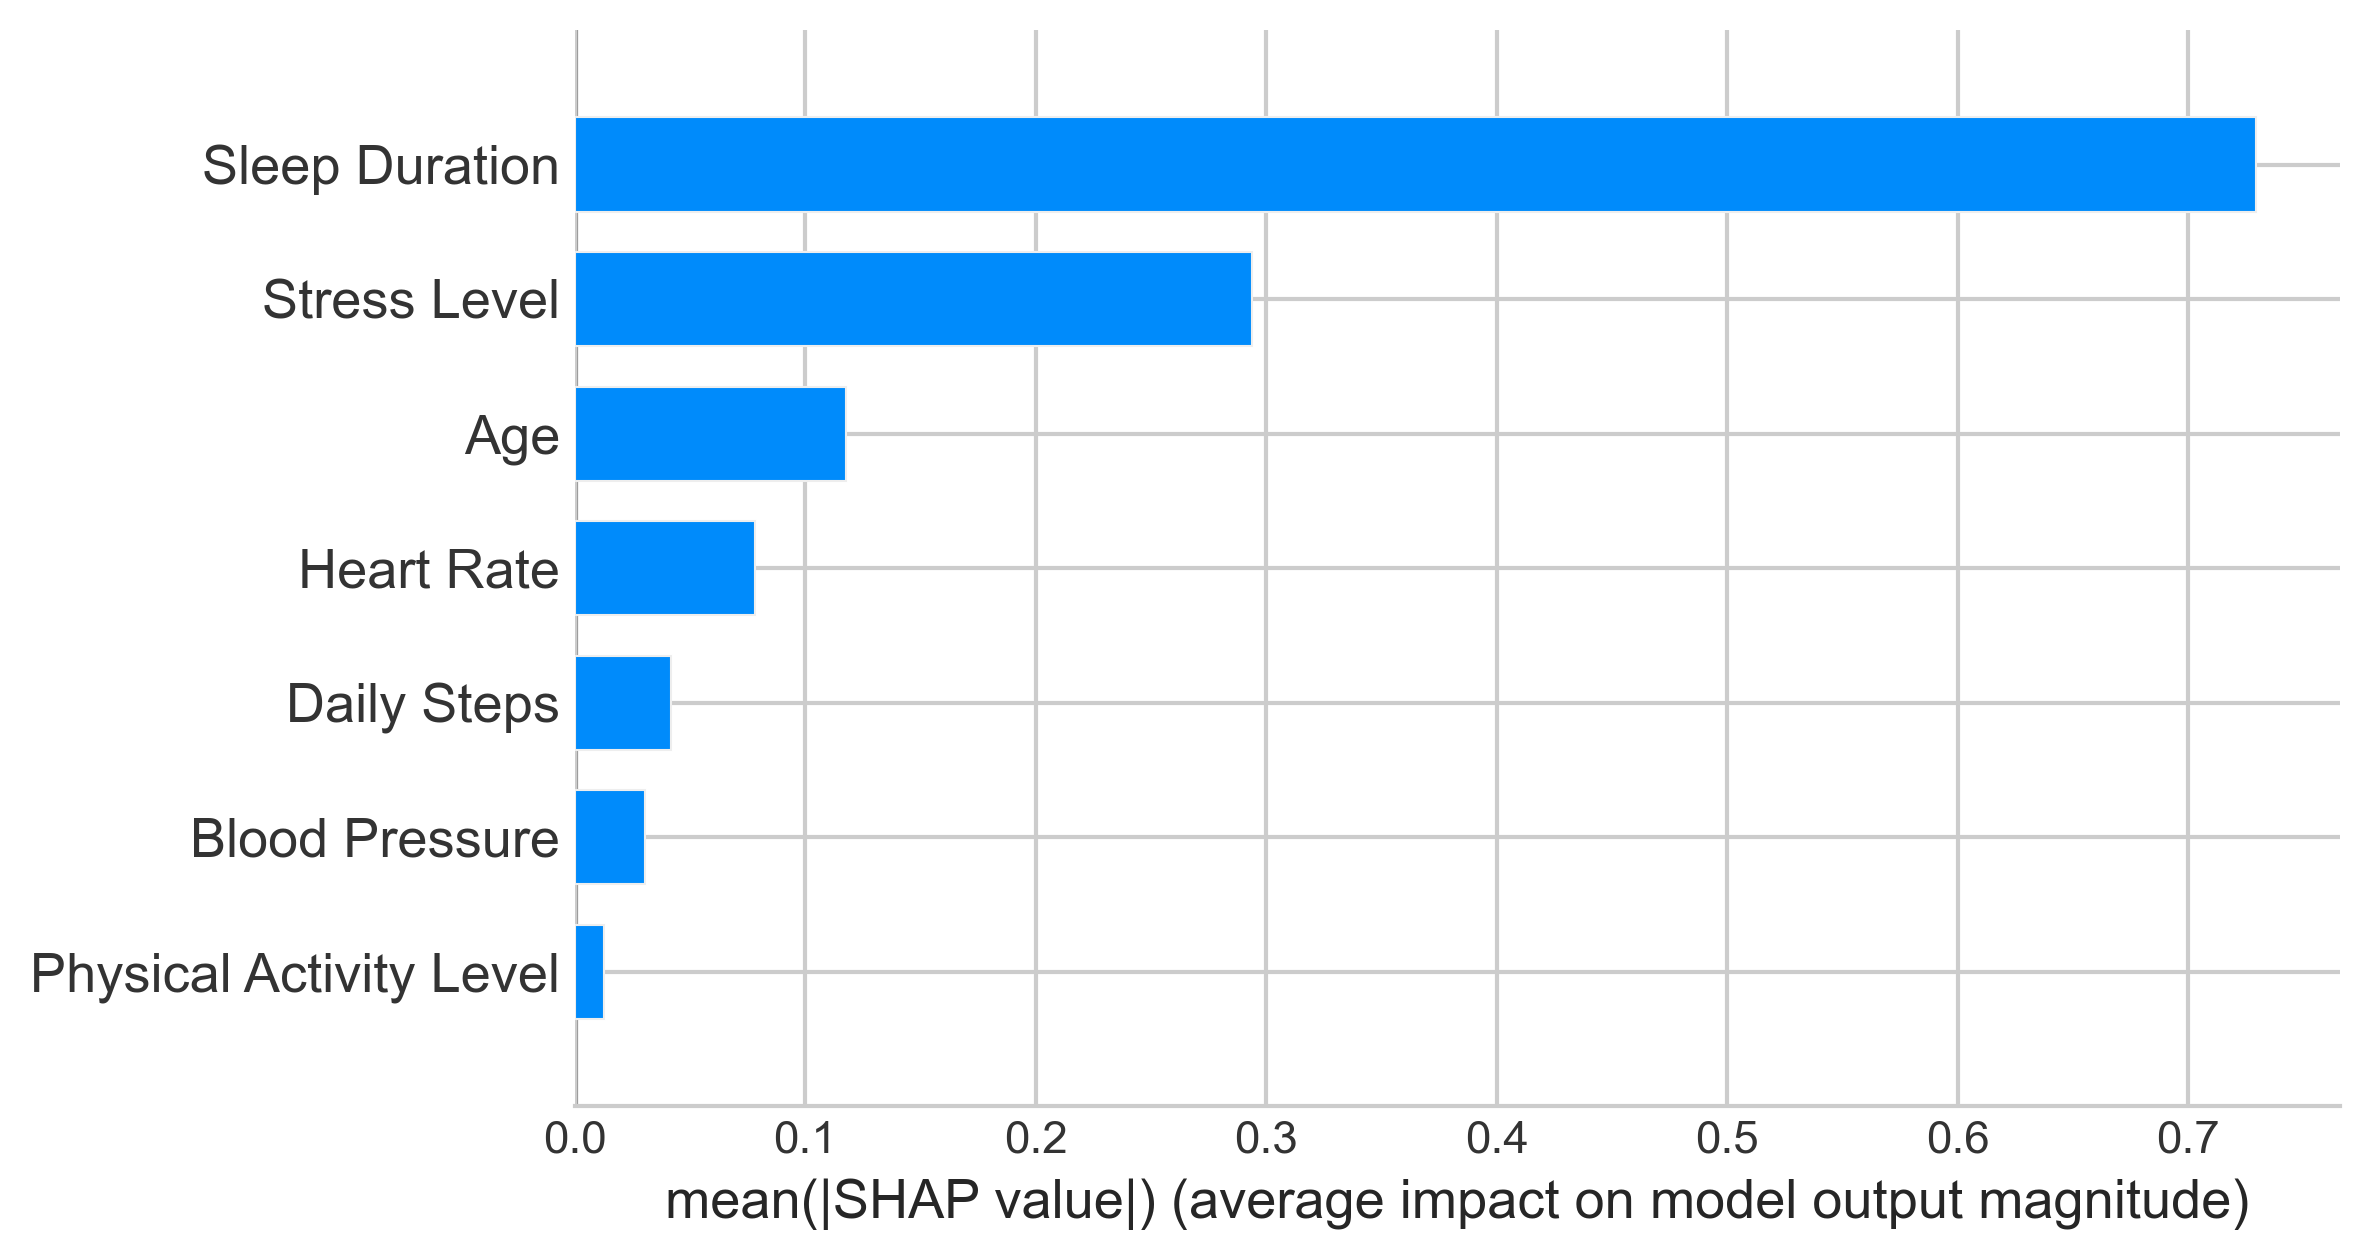

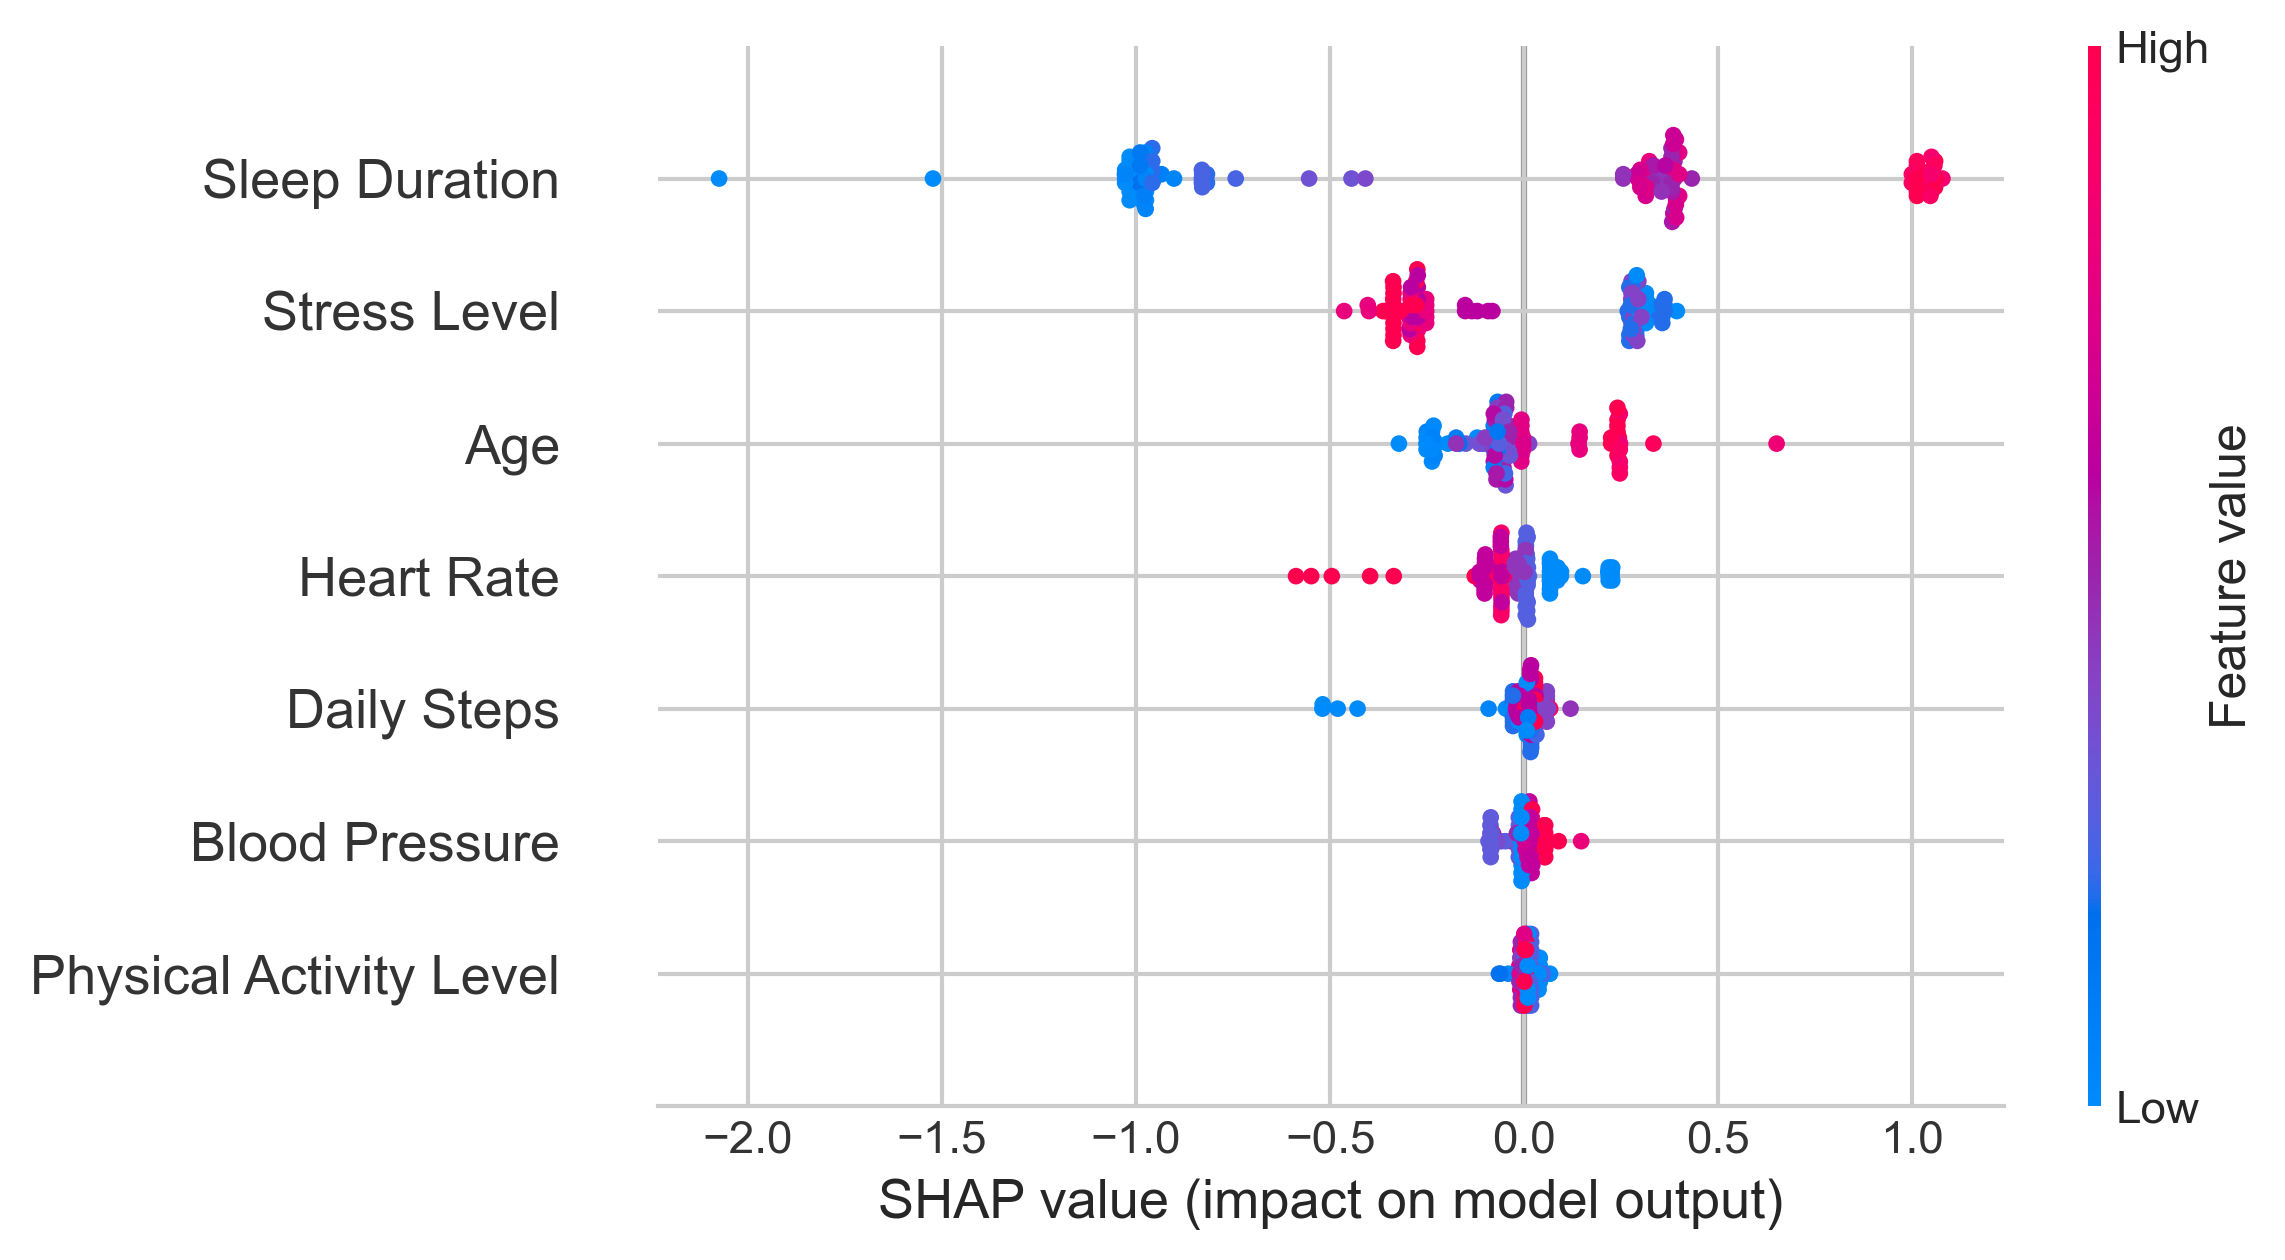

In [15]:
!pip install shap
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Integer, Real

# 设置全局种子
SEED = 777
np.random.seed(SEED)

# 数据加载和预处理
data = pd.read_csv('1.csv')
X = data.drop('Quality of Sleep', axis=1)
y = data['Quality of Sleep']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

# 归一化处理
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定义XGBoost模型
xgb_model = xgb.XGBRegressor(random_state=SEED, n_jobs=1)

# 贝叶斯优化超参数空间
param_space = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 30),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.1, 1.0),
    'min_child_weight': Integer(1, 20),
    'gamma': Real(0, 10),
    'reg_alpha': Real(0, 10),
    'reg_lambda': Real(0, 10)
}

# 贝叶斯优化设置
bayes_cv = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=param_space,
    scoring='neg_mean_absolute_error',  # 使用MAE作为优化目标
    cv=5,  # 5折交叉验证
    n_iter=30,  # 贝叶斯优化迭代次数
    n_jobs=-1,
    random_state=SEED
)

# 执行贝叶斯优化
bayes_cv.fit(X_train_scaled, y_train)

# 最佳模型
best_xgb = bayes_cv.best_estimator_

# 训练集预测
y_train_pred = best_xgb.predict(X_train_scaled)

# 测试集预测
y_test_pred = best_xgb.predict(X_test_scaled)

# 评估函数
def evaluate(y_true, y_pred):
    return {
        'R2': round(r2_score(y_true, y_pred), 4),
        'MAE': round(mean_absolute_error(y_true, y_pred), 4),
        'RMSE': round(np.sqrt(mean_squared_error(y_true, y_pred)), 4)
    }

# 输出结果
test_metrics = evaluate(y_test, y_test_pred)

print("\n测试集表现：")
print(f"R²: {test_metrics['R2']}, MAE: {test_metrics['MAE']}, RMSE: {test_metrics['RMSE']}")

# 输出最佳参数
print("\n最佳参数组合：")
print(bayes_cv.best_params_)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 8), dpi=300)

# 计算坐标轴范围
data_min = min(y_test.min(), y_test_pred.min())
data_max = max(y_test.max(), y_test_pred.max())
buffer = (data_max - data_min) * 0.05  # 5%边界缓冲

# 创建六边形分箱图
hexbin = plt.hexbin(y_test_pred, y_test,
                   gridsize=15,            # 控制分箱粒度
                   cmap='viridis',         # 使用色盲友好色谱
                   mincnt=1,              # 显示至少包含1个点的分箱
                   edgecolors='none',     # 移除分箱边界线
                   extent=(data_min - buffer, data_max + buffer, 
                           data_min - buffer, data_max + buffer))

# 添加参考线
ref_line = np.linspace(data_min - buffer, data_max + buffer, 100)
plt.plot(ref_line, ref_line, '--', color='#d7191c', lw=2, alpha=0.8)

# 添加颜色条
cbar = plt.colorbar(hexbin, pad=0.02)
cbar.set_label('Data Point Density', rotation=270, labelpad=20)

# 添加统计标注
stats_text = (
    f"R² = {test_metrics['R2']:.3f}\n"
    f"MAE = {test_metrics['MAE']:.3f}\n"
    f"RMSE = {test_metrics['RMSE']:.3f}"
)
plt.gcf().text(0.15, 0.82, stats_text, 
              fontsize=12,
              bbox=dict(facecolor='white', alpha=0.9, edgecolor='none'))

# 设置坐标轴
plt.xlabel('Predicted Values', fontsize=14, labelpad=10)
plt.ylabel('True Values', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 设置标题
plt.title('True vs Predicted Values (Hexbin Density)', 
         fontsize=16, pad=20)

# 保存矢量图
plt.savefig('hexbin_plot.pdf', bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

import shap


rng = np.random.default_rng(SEED)


explainer = shap.TreeExplainer(best_xgb)


shap_values = explainer.shap_values(X_test_scaled)


shap.summary_plot(shap_values, features=X_test_scaled, feature_names=X.columns, plot_type="bar")


shap.summary_plot(shap_values, features=X_test_scaled, feature_names=X.columns, show=True, plot_type="dot", color_bar=True, alpha=1, rng=rng)

/opt/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1, 'distance'] before, using random point [29, 1, 'distance']
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1, 'uniform'] before, using random point [11, 2, 'uniform']
  warnings.warn(



测试集表现：
R²: 0.9749, MAE: 0.0354, RMSE: 0.1881

最佳参数组合：
OrderedDict({'n_neighbors': 1, 'p': 1, 'weights': 'uniform'})


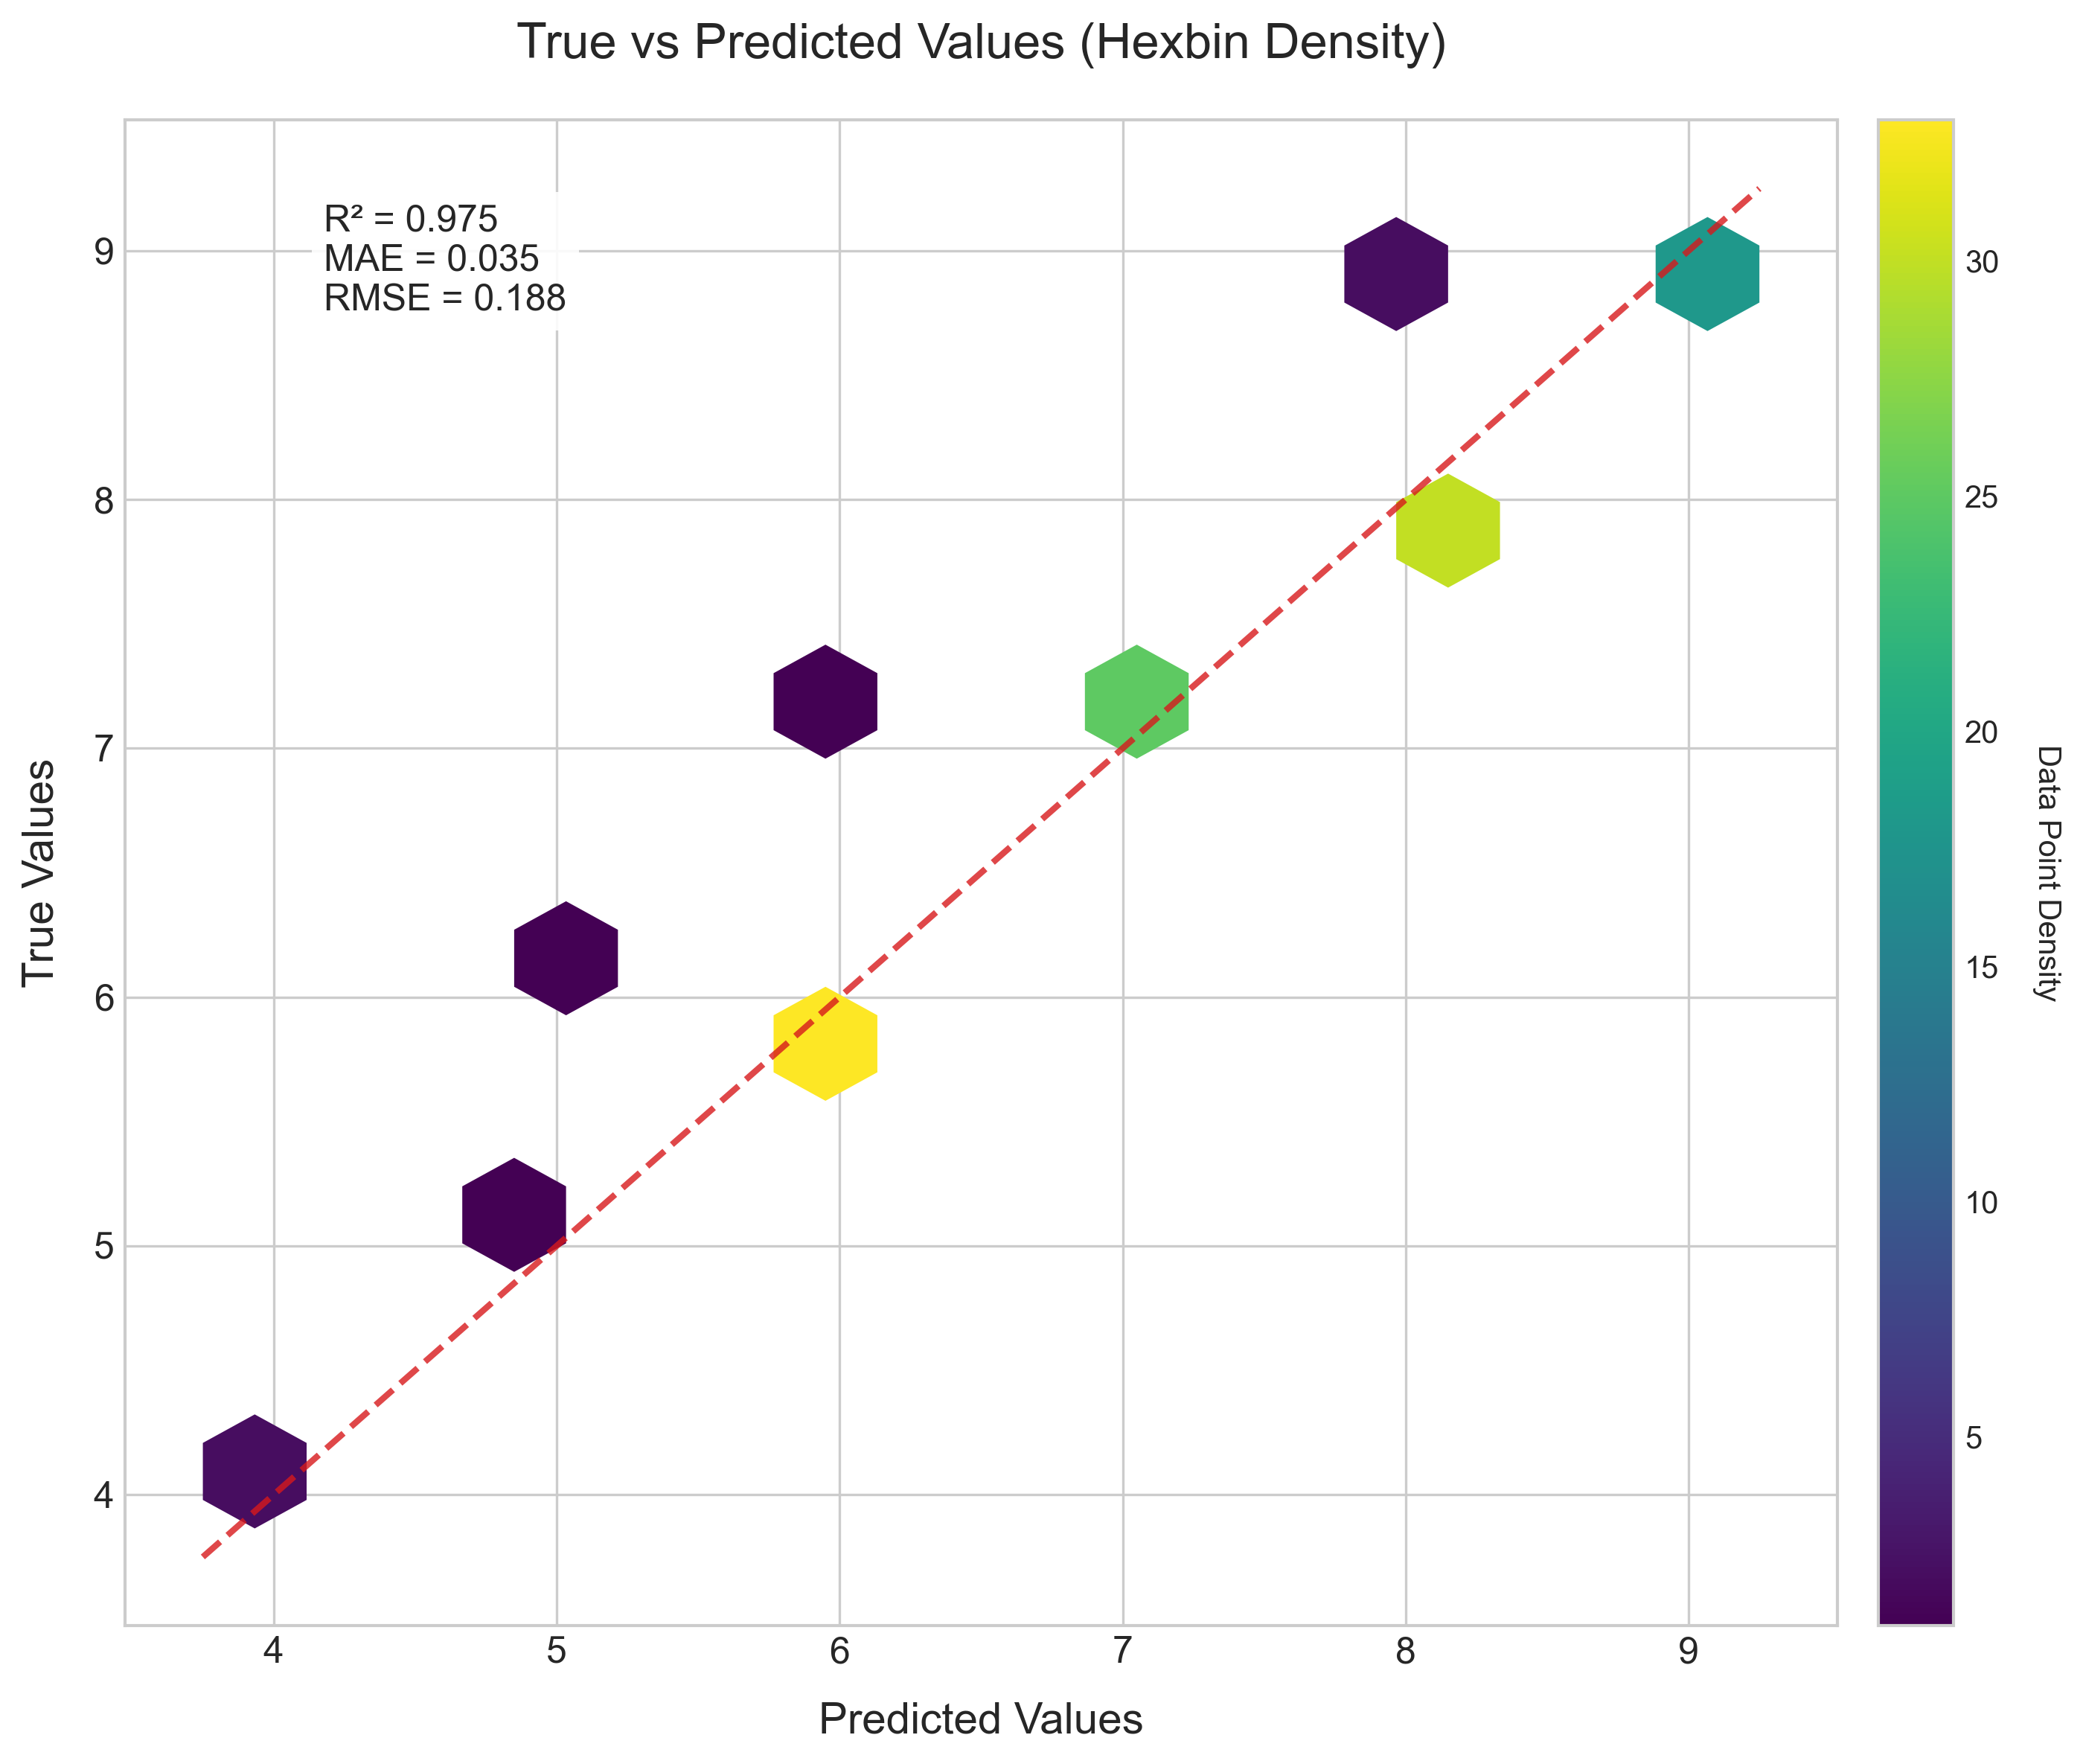

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

# 设置全局种子
SEED = 777
np.random.seed(SEED)

# 数据加载和预处理
data = pd.read_csv('1.csv')
X = data.drop('Quality of Sleep', axis=1)
y = data['Quality of Sleep']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

# 归一化处理（对KNN非常重要）
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定义KNN回归模型 
knn = KNeighborsRegressor()

# 贝叶斯优化超参数空间
param_space = {
    'n_neighbors': Integer(1, 30),          # 邻居数量范围
    'weights': Categorical(['uniform', 'distance']),  # 权重类型
    'p': Integer(1, 2)                      # 距离度量（1=曼哈顿，2=欧氏）
}

# 贝叶斯优化设置
bayes_cv = BayesSearchCV(
    estimator=knn, 
    search_spaces=param_space,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_iter=30,
    n_jobs=-1,
    random_state=SEED
)

# 执行贝叶斯优化
bayes_cv.fit(X_train_scaled, y_train)

# 最佳模型
best_knn = bayes_cv.best_estimator_  

# 训练集预测
y_train_pred = best_knn.predict(X_train_scaled)

# 测试集预测
y_test_pred = best_knn.predict(X_test_scaled)

# 评估函数（保持不变）
def evaluate(y_true, y_pred):
    return {
        'R2': round(r2_score(y_true, y_pred), 4),
        'MAE': round(mean_absolute_error(y_true, y_pred), 4),
        'RMSE': round(np.sqrt(mean_squared_error(y_true, y_pred)), 4)
    }

# 输出结果
test_metrics = evaluate(y_test, y_test_pred)

print("\n测试集表现：")
print(f"R²: {test_metrics['R2']}, MAE: {test_metrics['MAE']}, RMSE: {test_metrics['RMSE']}")

# 输出最佳参数
print("\n最佳参数组合：")
print(bayes_cv.best_params_)


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 8), dpi=300)

# 计算坐标轴范围
data_min = min(y_test.min(), y_test_pred.min())
data_max = max(y_test.max(), y_test_pred.max())
buffer = (data_max - data_min) * 0.05  # 5%边界缓冲

# 创建六边形分箱图
hexbin = plt.hexbin(y_test_pred, y_test,
                   gridsize=15,            # 控制分箱粒度
                   cmap='viridis',         # 使用色盲友好色谱
                   mincnt=1,              # 显示至少包含1个点的分箱
                   edgecolors='none',     # 移除分箱边界线
                   extent=(data_min - buffer, data_max + buffer, 
                           data_min - buffer, data_max + buffer))

# 添加参考线
ref_line = np.linspace(data_min - buffer, data_max + buffer, 100)
plt.plot(ref_line, ref_line, '--', color='#d7191c', lw=2, alpha=0.8)

# 添加颜色条
cbar = plt.colorbar(hexbin, pad=0.02)
cbar.set_label('Data Point Density', rotation=270, labelpad=20)

# 添加统计标注
stats_text = (
    f"R² = {test_metrics['R2']:.3f}\n"
    f"MAE = {test_metrics['MAE']:.3f}\n"
    f"RMSE = {test_metrics['RMSE']:.3f}"
)
plt.gcf().text(0.15, 0.82, stats_text, 
              fontsize=12,
              bbox=dict(facecolor='white', alpha=0.9, edgecolor='none'))

# 设置坐标轴
plt.xlabel('Predicted Values', fontsize=14, labelpad=10)
plt.ylabel('True Values', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 设置标题
plt.title('True vs Predicted Values (Hexbin Density)', 
         fontsize=16, pad=20)

# 保存矢量图
plt.savefig('hexbin_plot.pdf', bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()


测试集表现：
R²: 0.9457, MAE: 0.0896, RMSE: 0.2764

最佳参数组合：
OrderedDict({'C': 130.2000887369319, 'epsilon': 0.01863450076684638, 'gamma': 0.1496094023515622, 'kernel': 'rbf'})


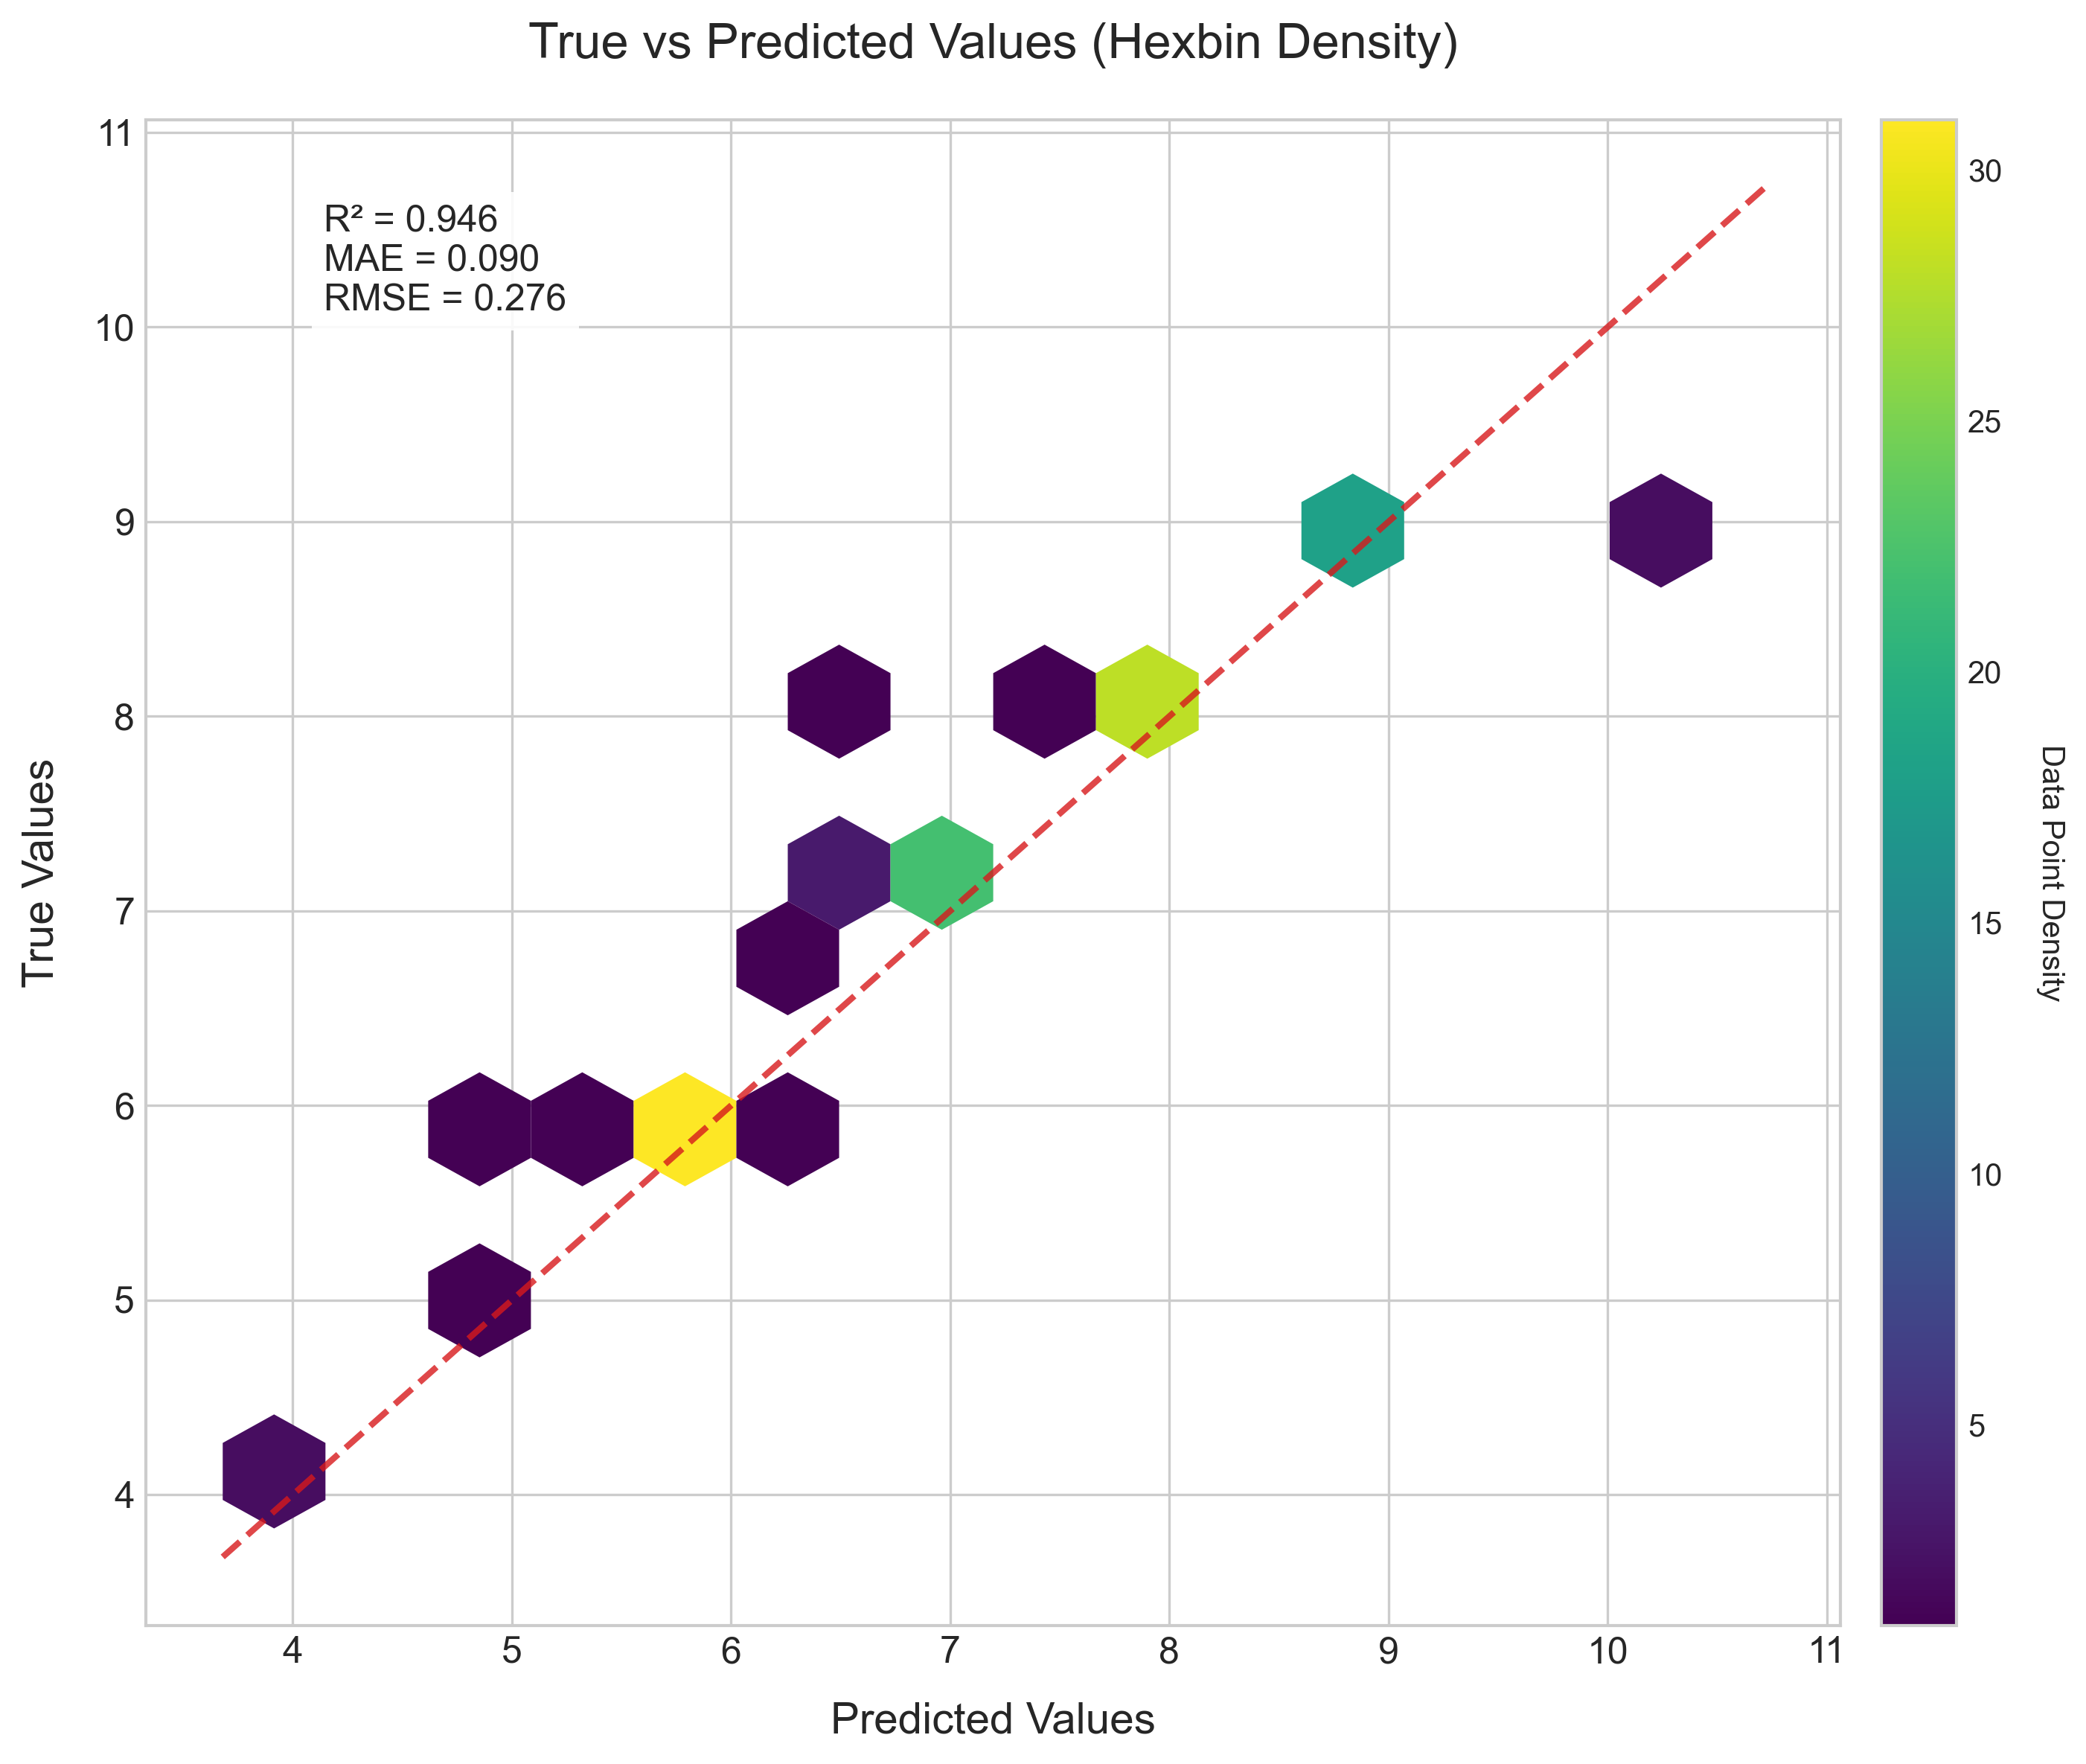

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical

# 设置全局种子
SEED = 777
np.random.seed(SEED)

# 数据加载和预处理
data = pd.read_csv('1.csv')
X = data.drop('Quality of Sleep', axis=1)
y = data['Quality of Sleep']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

# 归一化处理
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定义SVR模型
svr = SVR()

# 贝叶斯优化超参数空间
param_space = {
    'C': Real(1e-3, 1e3, prior='log-uniform'),
    'epsilon': Real(1e-3, 1.0, prior='log-uniform'),
    'kernel': Categorical(['linear', 'rbf', 'poly', 'sigmoid']),
    'gamma': Real(1e-5, 1e2, prior='log-uniform')
}

# 贝叶斯优化设置
bayes_cv = BayesSearchCV(
    estimator=svr,
    search_spaces=param_space,
    scoring='neg_mean_absolute_error',  # 使用MAE作为优化目标
    cv=5,  # 5折交叉验证
    n_iter=30,  # 贝叶斯优化迭代次数
    n_jobs=-1,
    random_state=SEED
)

# 执行贝叶斯优化
bayes_cv.fit(X_train_scaled, y_train)

# 最佳模型
best_svr = bayes_cv.best_estimator_

# 训练集预测
y_train_pred = best_svr.predict(X_train_scaled)

# 测试集预测
y_test_pred = best_svr.predict(X_test_scaled)

# 评估函数
def evaluate(y_true, y_pred):
    return {
        'R2': round(r2_score(y_true, y_pred), 4),
        'MAE': round(mean_absolute_error(y_true, y_pred), 4),
        'RMSE': round(np.sqrt(mean_squared_error(y_true, y_pred)), 4)
    }

# 输出结果
test_metrics = evaluate(y_test, y_test_pred)

print("\n测试集表现：")
print(f"R²: {test_metrics['R2']}, MAE: {test_metrics['MAE']}, RMSE: {test_metrics['RMSE']}")

# 输出最佳参数
print("\n最佳参数组合：")
print(bayes_cv.best_params_)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 8), dpi=300)

# 计算坐标轴范围
data_min = min(y_test.min(), y_test_pred.min())
data_max = max(y_test.max(), y_test_pred.max())
buffer = (data_max - data_min) * 0.05  # 5%边界缓冲

# 创建六边形分箱图
hexbin = plt.hexbin(y_test_pred, y_test,
                   gridsize=15,            # 控制分箱粒度
                   cmap='viridis',         # 使用色盲友好色谱
                   mincnt=1,              # 显示至少包含1个点的分箱
                   edgecolors='none',     # 移除分箱边界线
                   extent=(data_min - buffer, data_max + buffer, 
                           data_min - buffer, data_max + buffer))

# 添加参考线
ref_line = np.linspace(data_min - buffer, data_max + buffer, 100)
plt.plot(ref_line, ref_line, '--', color='#d7191c', lw=2, alpha=0.8)

# 添加颜色条
cbar = plt.colorbar(hexbin, pad=0.02)
cbar.set_label('Data Point Density', rotation=270, labelpad=20)

# 添加统计标注
stats_text = (
    f"R² = {test_metrics['R2']:.3f}\n"
    f"MAE = {test_metrics['MAE']:.3f}\n"
    f"RMSE = {test_metrics['RMSE']:.3f}"
)
plt.gcf().text(0.15, 0.82, stats_text, 
              fontsize=12,
              bbox=dict(facecolor='white', alpha=0.9, edgecolor='none'))

# 设置坐标轴
plt.xlabel('Predicted Values', fontsize=14, labelpad=10)
plt.ylabel('True Values', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 设置标题
plt.title('True vs Predicted Values (Hexbin Density)', 
         fontsize=16, pad=20)

# 保存矢量图
plt.savefig('hexbin_plot.pdf', bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['relu', 1e-05, 16, 200, 'adaptive', 0.1, 'sgd'] before, using random point ['logistic', 0.03739141108312294, 76, 143, 'constant', 0.05159650913606036, 'sgd']
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['relu', 1e-05, 16, 200, 'adaptive', 0.1, 'sgd'] before, using random point ['logistic', 0.005134501142999954, 103, 75, 'constant', 0.022175986778570047, 'adam']
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['relu', 1e-05, 16, 200, 'adaptive', 0.1, 'sgd'] before, using random point ['logistic', 0.026375379964929863, 85, 142, 'adaptive', 0.03210454665314465, 'sgd']
  warnings.warn(



测试集表现：
R²: 0.9655, MAE: 0.1192, RMSE: 0.2205

最佳参数组合：
OrderedDict({'activation': 'relu', 'alpha': 1e-05, 'batch_size': 16, 'hidden_layer_sizes': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'solver': 'sgd'})


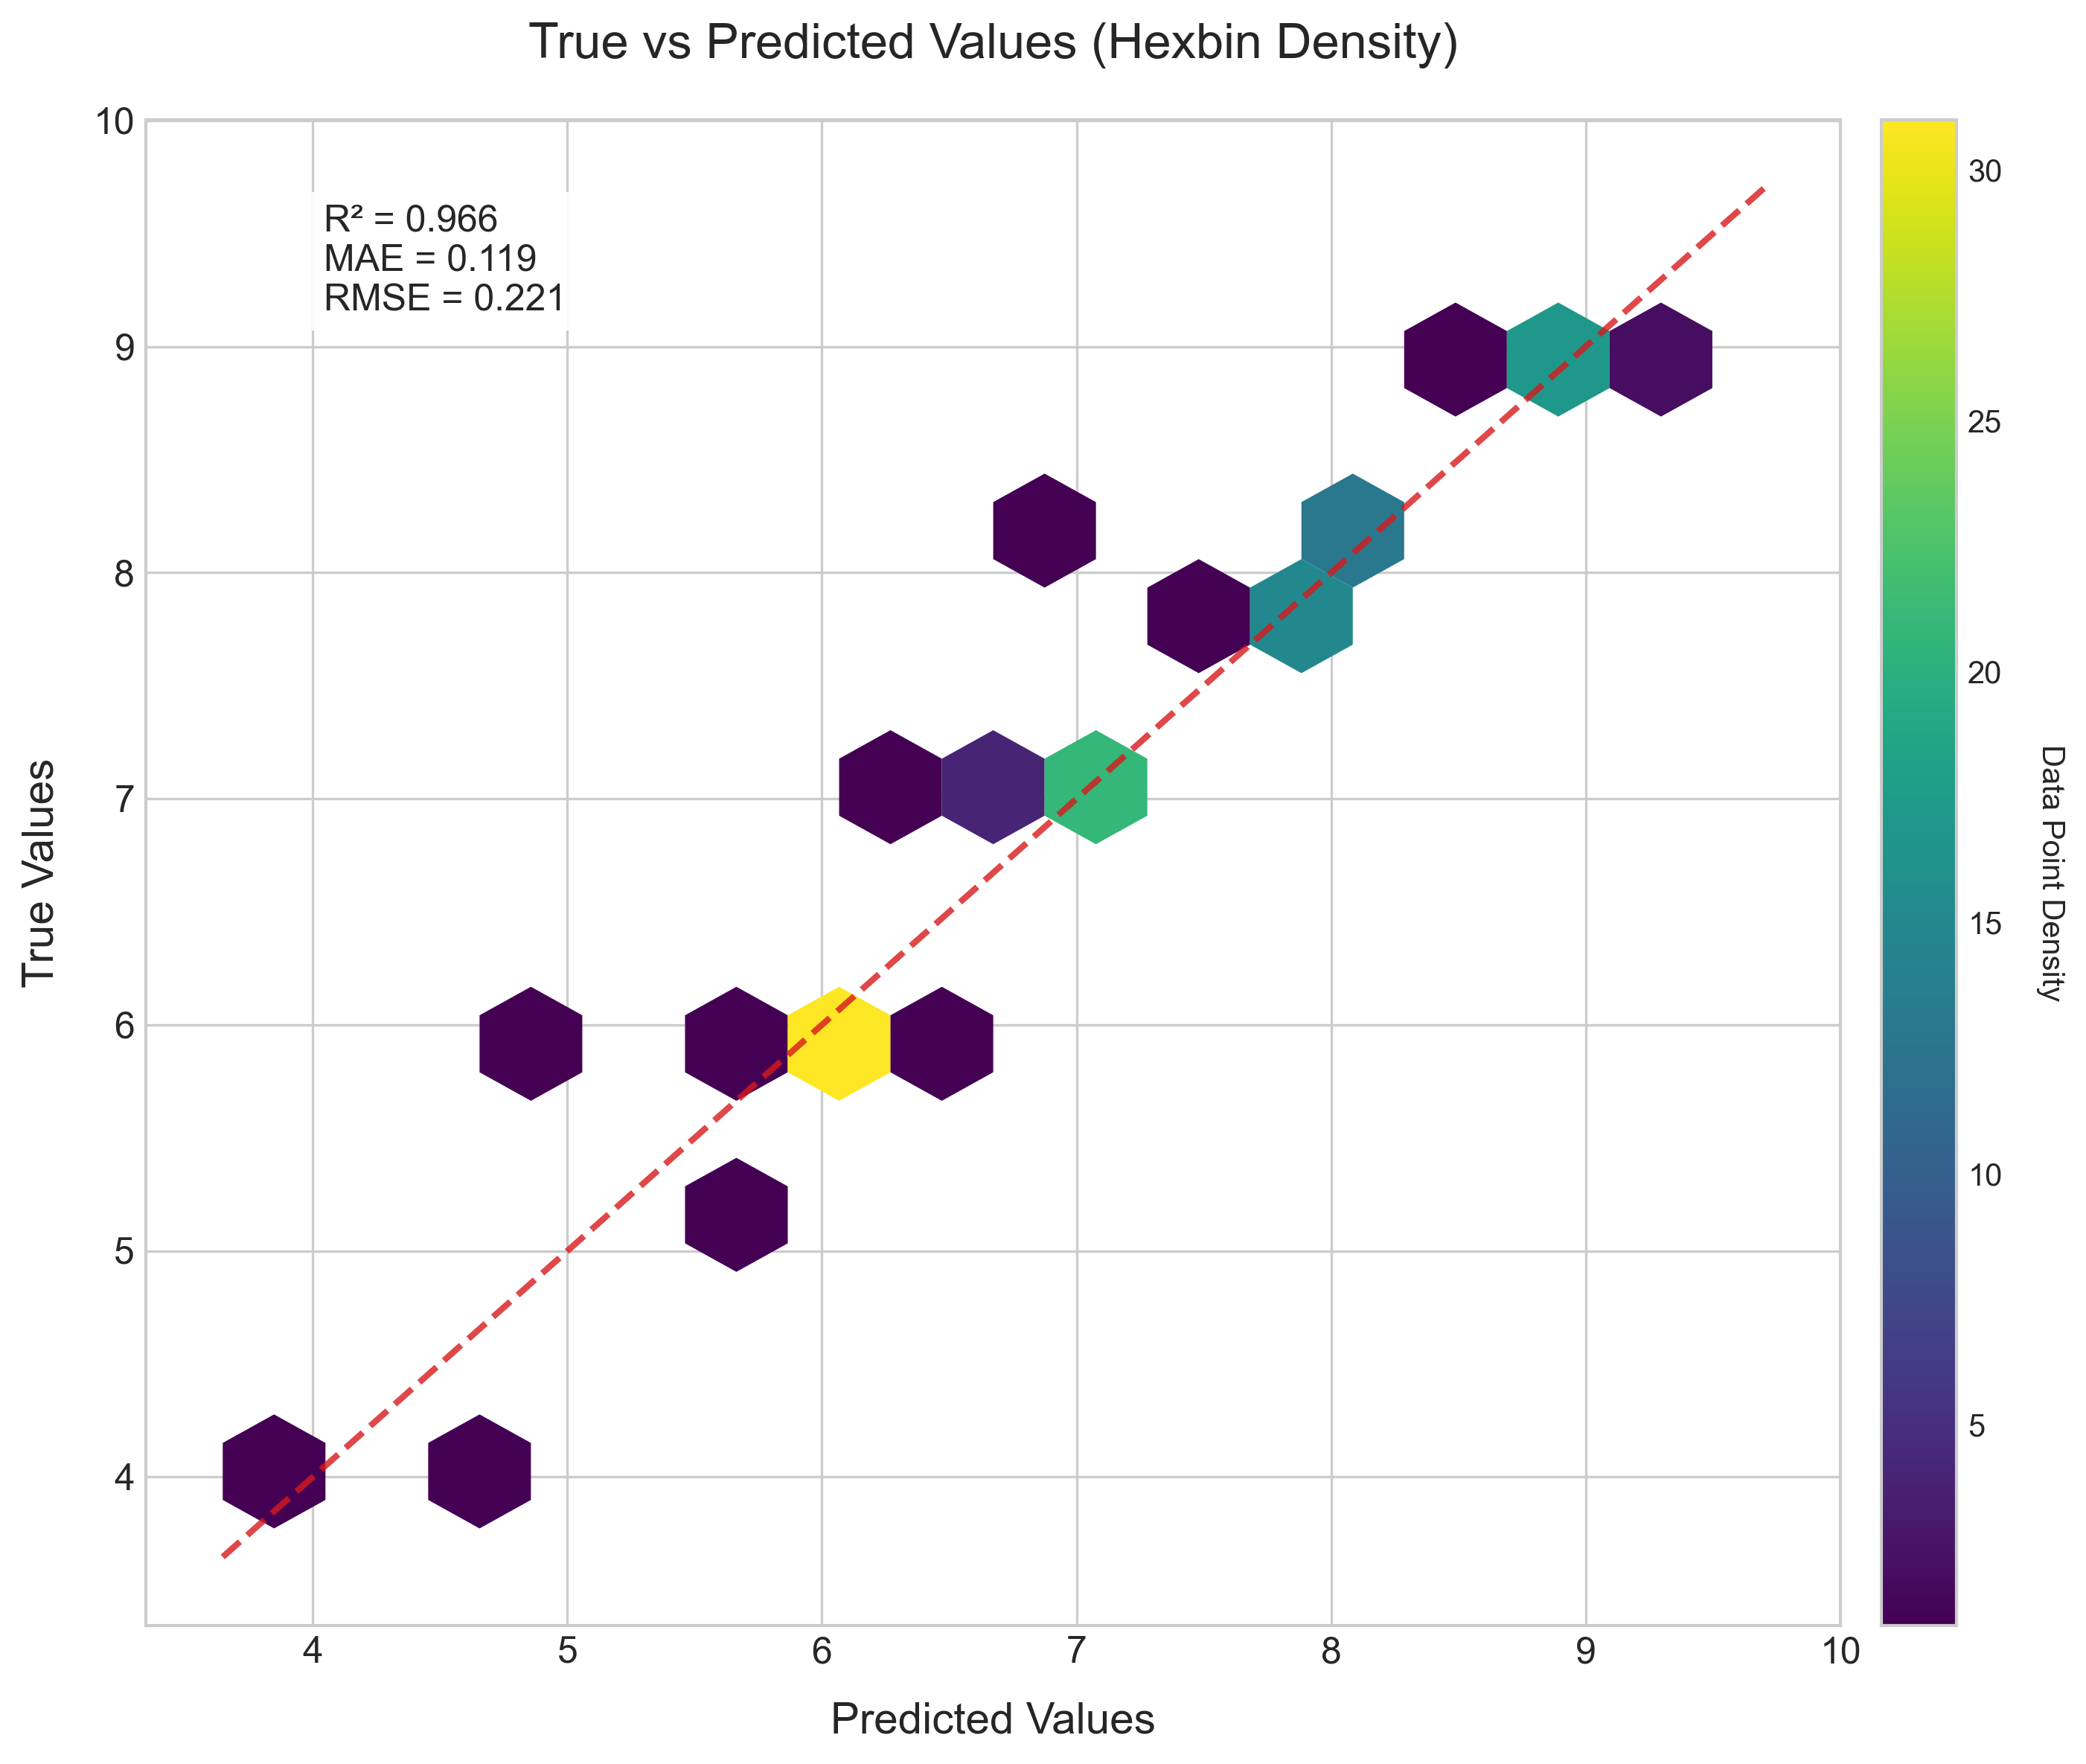

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

# 设置全局种子
SEED = 777
np.random.seed(SEED)

# 数据加载和预处理
data = pd.read_csv('1.csv')
X = data.drop('Quality of Sleep', axis=1)
y = data['Quality of Sleep']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

# 归一化处理
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定义MLP模型
mlp = MLPRegressor(random_state=SEED, early_stopping=True, max_iter=3000)

# 贝叶斯优化超参数空间
param_space = {
    'hidden_layer_sizes': Integer(50, 200),  # 单隐藏层节点数
    'activation': Categorical(['relu', 'tanh', 'logistic']),
    'alpha': Real(1e-5, 1e-1, prior='log-uniform'),  # L2正则化
    'learning_rate_init': Real(1e-4, 1e-1, prior='log-uniform'),
    'batch_size': Integer(16, 128),
    'solver': Categorical(['adam', 'sgd']),
    'learning_rate': Categorical(['constant', 'adaptive'])
}

# 贝叶斯优化设置
bayes_cv = BayesSearchCV(
    estimator=mlp,
    search_spaces=param_space,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_iter=30,
    n_jobs=-1,
    random_state=SEED
)

# 执行贝叶斯优化
bayes_cv.fit(X_train_scaled, y_train)

# 最佳模型
best_mlp = bayes_cv.best_estimator_

# 训练集预测
y_train_pred = best_mlp.predict(X_train_scaled)

# 测试集预测
y_test_pred = best_mlp.predict(X_test_scaled)

# 评估函数
def evaluate(y_true, y_pred):
    return {
        'R2': round(r2_score(y_true, y_pred), 4),
        'MAE': round(mean_absolute_error(y_true, y_pred), 4),
        'RMSE': round(np.sqrt(mean_squared_error(y_true, y_pred)), 4)
    }

# 输出结果

test_metrics = evaluate(y_test, y_test_pred)

print("\n测试集表现：")
print(f"R²: {test_metrics['R2']}, MAE: {test_metrics['MAE']}, RMSE: {test_metrics['RMSE']}")

# 输出最佳参数
print("\n最佳参数组合：")
print(bayes_cv.best_params_)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 8), dpi=300)

# 计算坐标轴范围
data_min = min(y_test.min(), y_test_pred.min())
data_max = max(y_test.max(), y_test_pred.max())
buffer = (data_max - data_min) * 0.05  # 5%边界缓冲

# 创建六边形分箱图
hexbin = plt.hexbin(y_test_pred, y_test,
                   gridsize=15,            # 控制分箱粒度
                   cmap='viridis',         # 使用色盲友好色谱
                   mincnt=1,              # 显示至少包含1个点的分箱
                   edgecolors='none',     # 移除分箱边界线
                   extent=(data_min - buffer, data_max + buffer, 
                           data_min - buffer, data_max + buffer))

# 添加参考线
ref_line = np.linspace(data_min - buffer, data_max + buffer, 100)
plt.plot(ref_line, ref_line, '--', color='#d7191c', lw=2, alpha=0.8)

# 添加颜色条
cbar = plt.colorbar(hexbin, pad=0.02)
cbar.set_label('Data Point Density', rotation=270, labelpad=20)

# 添加统计标注
stats_text = (
    f"R² = {test_metrics['R2']:.3f}\n"
    f"MAE = {test_metrics['MAE']:.3f}\n"
    f"RMSE = {test_metrics['RMSE']:.3f}"
)
plt.gcf().text(0.15, 0.82, stats_text, 
              fontsize=12,
              bbox=dict(facecolor='white', alpha=0.9, edgecolor='none'))

# 设置坐标轴
plt.xlabel('Predicted Values', fontsize=14, labelpad=10)
plt.ylabel('True Values', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 设置标题
plt.title('True vs Predicted Values (Hexbin Density)', 
         fontsize=16, pad=20)

# 保存矢量图
plt.savefig('hexbin_plot.pdf', bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

In [16]:

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from skopt import BayesSearchCV
from skopt.space import Integer, Real
import joblib

# 设置全局种子
SEED = 777
np.random.seed(SEED)

# 显式定义特征顺序（根据数据集的列顺序）
FEATURE_ORDER = [
    'Age',
    'Sleep Duration',
    'Physical Activity Level',
    'Stress Level',
    'Heart Rate',
    'Daily Steps',
    'Blood Pressure'  # 注意：保持原始数值形式
]

TARGET_COL = 'Quality of Sleep'

# 数据加载和预处理
data = pd.read_csv('1.csv')
X = data[FEATURE_ORDER]  # 显式指定特征顺序
y = data[TARGET_COL]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED
)

# 归一化处理
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 贝叶斯优化设置
param_space = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 30),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.1, 1.0),
    'min_child_weight': Integer(1, 20),
    'gamma': Real(0, 10),
    'reg_alpha': Real(0, 10),
    'reg_lambda': Real(0, 10)
}

bayes_cv = BayesSearchCV(
    estimator=xgb.XGBRegressor(random_state=SEED, n_jobs=1),
    search_spaces=param_space,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_iter=30,
    n_jobs=-1,
    random_state=SEED
)

# 训练模型
bayes_cv.fit(X_train_scaled, y_train)

# 保存最佳模型和预处理对象
best_model = bayes_cv.best_estimator_
best_model.save_model('1/xgb_model.ubj')  # XGBoost原生格式
joblib.dump(scaler, '1/minmax_scaler.joblib')  # Scaler保存

# 保存特征顺序元数据
with open('1/feature_order.txt', 'w') as f:
    f.write('\n'.join(FEATURE_ORDER))

# 验证特征顺序一致性
print("验证特征顺序:")
print("训练数据特征:", FEATURE_ORDER)
print("实际数据特征:", list(X.columns))
assert list(X.columns) == FEATURE_ORDER, "特征顺序不一致！"

验证特征顺序:
训练数据特征: ['Age', 'Sleep Duration', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps', 'Blood Pressure']
实际数据特征: ['Age', 'Sleep Duration', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps', 'Blood Pressure']


In [18]:
import sys
print(sys.version)

3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 10:07:17) [Clang 14.0.6 ]
